# Analyse qualitative

Uniquement sur les données où les référentiels d'Île-de-France ont été intégrés

In [1]:
import pandas as pd
import geopandas
import json
from shapely.geometry import Point
import folium
import difflib
from geopy.distance import vincenty
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
inline_rc = dict(mpl.rcParams)



## Mapping des routepoints (reflex, coddifligne, terminus)

Chargement des routepoints OSM et GTFS

In [2]:
quali_osm_routepoints = pd.read_csv("ref_data/audit1/osm_routepoints_for_matching.csv", dtype=str)
for c in quali_osm_routepoints.columns:
    new_col = "osm_" + c
    quali_osm_routepoints.rename(columns={c: new_col}, inplace=True)

gtfs_routepoints = pd.read_csv("ref_data/audit1/opendata_routepoints.csv", dtype=str)
for c in gtfs_routepoints.columns:
    new_col = "gtfs_" + c
    gtfs_routepoints.rename(columns={c: new_col}, inplace=True)
    
print("On a {:d} routepoints dans OSM et {:d} routepoints dans le GTFS".format(quali_osm_routepoints.shape[0], gtfs_routepoints.shape[0]))



On a 10668 routepoints dans OSM et 103567 routepoints dans le GTFS


On fusionne les routepoints par code REFLEX, Codifligne et on calcule la correspondance de terminus

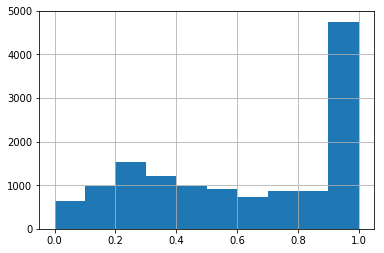

In [3]:
quali_gtfs_routepoints = gtfs_routepoints.copy().fillna("")
quali_gtfs_routepoints = quali_gtfs_routepoints[quali_gtfs_routepoints['gtfs_ZDEr_ID_REF_A'] != '']

#on fusionne sur les codes d'arrêts et les codes de lignes
quali_routepoints = quali_gtfs_routepoints.merge(
                    quali_osm_routepoints, how='inner', 
                    right_on=["osm_osm:ref:FR:STIF", "osm_osm:ref:FR:STIF:ExternalCode_Line"],
                    left_on=["gtfs_ZDEr_ID_REF_A", "gtfs_route_id"]
               )
quali_routepoints.fillna("", inplace=True)

def compute_similarity_lower(elem1, elem2):
    return difflib.SequenceMatcher(None, elem1.lower(), elem2.lower()).ratio()

def compute_similarity(elem1, elem2):
    return difflib.SequenceMatcher(None, elem1, elem2).ratio()

#on fusionne sur les terminus de lignes
quali_routepoints['destination_confidence'] = quali_routepoints[['osm_destination','gtfs_dest_name']].apply(lambda x: compute_similarity_lower(*x), axis=1)
quali_routepoints['destination_confidence'].hist()


**Pour la suite, on ne conserve que les routepoints qui matchent à 60% et plus**

In [4]:
quali_routepoints_filtered = quali_routepoints[quali_routepoints['destination_confidence'] >= 0.6].copy()
"{:d} routepoints matchant à plus de 60%".format(quali_routepoints_filtered.shape[0])

'7249 routepoints matchant à plus de 60%'

In [5]:
tt = len(quali_routepoints_filtered) * 100.0 / len(gtfs_routepoints)
"Pourcentage de routepoints qu'on considère pour la suite : {}".format(tt)

"Pourcentage de routepoints qu'on considère pour la suite : 6.999333764616142"

NB : le matching sur les terminus est loin d'être parfait. Pour de meilleurs résultats, il faudrait :
* soit un référentiel officiel des parcours (qui pourrait être importé dans les données OSM)
* soit établir un tableau de correspondance entre les terminus

(cf quelques contrexemples ci-dessous)

In [6]:
difflib.SequenceMatcher(None, 'A. Lebrun', '').ratio() #0
difflib.SequenceMatcher(None, 'Sucy-Bonneuil RER', 'Gare de Sucy-Bonneuil').ratio() # 0.68
difflib.SequenceMatcher(None, 'Cimetière', 'Cimetière de Saint-Maur-des-Fossés').ratio() #0.41
difflib.SequenceMatcher(None, 'A. Lebrun', 'Auguste Lebrun').ratio() #0.69
difflib.SequenceMatcher(None, 'Saint-Maur Créteil', 'SAINT-MAUR - CRETEIL RER').ratio() #0.23
difflib.SequenceMatcher(None, 'Saint-Maur Créteil'.lower(), 'SAINT-MAUR - CRETEIL RER'.lower()).ratio() #0.80

difflib.SequenceMatcher(None, 'Gare de Laplace (Arcueil)', 'Arcueil Laplace RER').ratio() # 0.5
difflib.SequenceMatcher(None, 'Noisy-le-Roi - Centre Commercial le Cèdre', 'Centre commercial').ratio() #0.55
difflib.SequenceMatcher(None, 'Massy', 'Gare RER Massy Palaiseau').ratio() #0.34
difflib.SequenceMatcher(None, 'Gare de La Verrière', 'LA VERRIERE NOCTILIEN'.lower()).ratio() #0.4

0.4

## Mesures qualitatives

## Analyse des codes de ligne

In [7]:
# différences sur les codes de ligne
quali_routepoints_filtered['line_code_confidence'] = quali_routepoints_filtered[['osm_code','gtfs_route_short_name']].apply(lambda x: compute_similarity(*x), axis=1)
quali_routepoints_filtered["line_code_confidence_rounded"] = quali_routepoints_filtered["line_code_confidence"].round(1) * 100

# quali_routepoints_and_line_volume
# quali_routepoints_filtered['line_code_confidence'].hist()

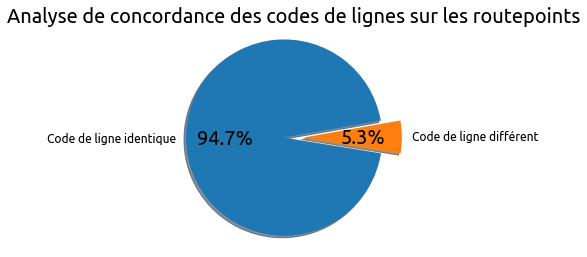

In [8]:
routepoints_count_total = quali_routepoints_filtered.shape[0]
routepoints_count_with_perfect_line_mapping = quali_routepoints_filtered[quali_routepoints_filtered["line_code_confidence_rounded"] == 100].shape[0]
routepoints_count_with_different_line_mapping = routepoints_count_total - routepoints_count_with_perfect_line_mapping
labels = 'Code de ligne identique', 'Code de ligne différent'


sizes = [routepoints_count_with_perfect_line_mapping/routepoints_count_total * 100, 
         routepoints_count_with_different_line_mapping/routepoints_count_total * 100]
explode = (0, 0.2)

mpl.rcParams.update(inline_rc) # reset du style 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 22
fig1, ax1 = plt.subplots()
ax1.set_title('Analyse de concordance des codes de lignes sur les routepoints')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [9]:
routepoints_with_different_line_mapping = quali_routepoints_filtered[quali_routepoints_filtered["line_code_confidence_rounded"] < 100]


lines_with_different_line_mapping = pd.DataFrame(routepoints_with_different_line_mapping.groupby(['gtfs_route_short_name', 'osm_code']).size()).reset_index()
print("Il y a {:d} lignes qui ne correspondent pas sur un total de {:d}".format(
    lines_with_different_line_mapping.shape[0],
    pd.DataFrame(quali_routepoints_filtered.groupby(['gtfs_route_short_name', 'osm_code']).size()).shape[0]
))
lines_with_different_line_mapping


Il y a 25 lignes qui ne correspondent pas sur un total de 305


,gtfs_route_short_name,osm_code,0
0,49,49a,26
1,49,49b,32
2,49,49c,37
3,7,FA,1
4,BIEVRES,513,1
5,CEN,Centaure,2
6,CHARONN,501,3
7,CHOISYB,582,21
8,CITA,Citalien,12
9,DIRECT 4,Direct 4,1


### Analyse des différence sur les noms des arrêts

In [ ]:
quali_routepoints_filtered['name_confidence'] = quali_routepoints_filtered[['osm_name','gtfs_stop_name']].apply(lambda x: compute_similarity(*x), axis=1)
quali_routepoints_filtered["name_confidence_rounded"] = quali_routepoints_filtered["name_confidence"].round(1) * 100
quali_routepoints_filtered['name_confidence_lower'] = quali_routepoints_filtered[['osm_name','gtfs_stop_name']].apply(lambda x: compute_similarity_lower(*x), axis=1)
quali_routepoints_filtered["name_confidence_lower_rounded"] = quali_routepoints_filtered["name_confidence_lower"].round(1) * 100
quali_routepoints_filtered_volume = pd.DataFrame(quali_routepoints_filtered.groupby('name_confidence_rounded').size()).reset_index()
quali_routepoints_filtered_volume.rename(columns={0: 'routepoints_count'}, inplace=True)
quali_routepoints_filtered_volume_lower = pd.DataFrame(quali_routepoints_filtered.groupby('name_confidence_lower_rounded').size()).reset_index()
quali_routepoints_filtered_volume_lower.rename(columns={0: 'routepoints_lower_count'}, inplace=True)
quali_routepoints_filtered_volume_lower
#quali_routepoints_and_line_filtered['name_confidence_lower'].hist()

In [ ]:
quali_routepoints_filtered_volume["name_confidence_rounded"]
quali_routepoints_filtered_volume["label"] = quali_routepoints_filtered_volume["name_confidence_rounded"].astype(int).astype(str) + " %"

width = 0.3
ind = np.arange(quali_routepoints_filtered_volume.shape[0])
fig, ax = plt.subplots(figsize=(10, 6))

rect1 = ax.bar(ind - width/2, quali_routepoints_filtered_volume["routepoints_count"], width, color='SkyBlue', label='avec majuscules')
rect2 = ax.bar(ind + width/2, quali_routepoints_filtered_volume_lower["routepoints_lower_count"], width, color='IndianRed', label='sans majuscules')
ax.set_ylabel('Nombre de routepoints')
ax.set_xlabel('Similitude')
ax.set_title("Analyse de similitude entre les noms des arrêts")
ax.set_xticks(ind)
ax.set_xticklabels(quali_routepoints_filtered_volume["label"], rotation=0, ha='center')
ax.grid(linestyle=(0, (5, 10)), axis='y', linewidth=1)
ax.legend()

Visualisation de quelques cas les plus différents (avec majuscules)

In [ ]:
quali_routepoints_filtered_ = quali_routepoints_filtered[quali_routepoints_filtered['name_confidence'] < 0.5]
quali_routepoints_filtered_ = quali_routepoints_filtered_[['gtfs_stop_name', 'osm_name']]
grouped = quali_routepoints_filtered_.groupby(['gtfs_stop_name', 'osm_name'])
index = [gp_keys[0] for gp_keys in grouped.groups.values()]
quali_unique_df = quali_routepoints_filtered_.reindex(index)
quali_unique_df.head()

VIsualisation des cas les plus différents (sans majuscules)

In [ ]:
quali_routepoints_filtered_ = quali_routepoints_filtered[quali_routepoints_filtered['name_confidence_lower'] < 0.5]
quali_routepoints_filtered_ = quali_routepoints_filtered_[['gtfs_stop_name', 'osm_name']]
grouped = quali_routepoints_filtered_.groupby(['gtfs_stop_name', 'osm_name'])
index = [gp_keys[0] for gp_keys in grouped.groups.values()]
quali_unique_df = quali_routepoints_filtered_.reindex(index)
quali_unique_df.head()

### Analyse des distances 

In [ ]:
def compute_distance(row):
    dist = vincenty(
        (float(row['osm_lat']), float(row['osm_lon'])), 
        (float(row['gtfs_stop_lat']), float(row['gtfs_stop_lon']))
    )
    return dist.meters
   
quali_routepoints_filtered['distance'] = quali_routepoints_filtered.apply(compute_distance, axis=1)

quali_routepoints_filtered['distance'].hist()

In [ ]:
routepoints_count = quali_routepoints_filtered.shape[0]
labels = 'moins de 50m', 'de 50m à 100m', 'plus de 100m'
count_moins_50 = quali_routepoints_filtered[quali_routepoints_filtered["distance"] <= 50].shape[0]
count_50_100 = quali_routepoints_filtered[(quali_routepoints_filtered["distance"] > 50) & (quali_routepoints_filtered["distance"] < 100)].shape[0]
count_plus_100 = quali_routepoints_filtered[quali_routepoints_filtered["distance"] > 100].shape[0]

sizes = [count_moins_50/routepoints_count * 100, 
         count_50_100/routepoints_count * 100,
         count_plus_100/routepoints_count * 100]
explode = (0, 0.1, 0.2)

fig1, ax1 = plt.subplots()
ax1.set_title('Distance entre les arrêts officiels et OSM')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
quali_routepoints_filtered['distance'].mean()

In [ ]:
nb_of_routepoints_ = quali_routepoints_filtered.groupby(['gtfs_agency_name'])[["distance"]].count().reset_index()
nb_of_routepoints_.rename(columns={'distance': 'number'}, inplace=True)

mean_distance_of_network_ = quali_routepoints_filtered.groupby(['gtfs_agency_name'])[["distance"]].mean().reset_index()
mean_distance_of_network_.rename(columns={'distance': 'mean_distance'}, inplace=True)


distance_by_number = pd.concat([nb_of_routepoints_, mean_distance_of_network_], axis=1)
distance_by_number.sort_values(by='mean_distance', ascending=False).head()
#bof, pas intéressant : les réseaux avec les plus gros écarts sont ceux où on a peu de routepoints

In [ ]:
routepoints_bad_position = quali_routepoints_filtered[quali_routepoints_filtered['distance'] > 80].copy()
print("Nombre de routepoints à plus de 80m : {:d}".format(len(routepoints_bad_position)))

In [ ]:
print("Nombre de stoppoints du GTFS à plus de 80m : {:d}".format(
    len(routepoints_bad_position.groupby(['gtfs_stop_id'])[["distance"]].count()))
)

In [ ]:
routepoints_bad_position.groupby(['gtfs_agency_name'])[["distance"]].mean().sort_values(by='distance', ascending=False).head()
# TODO : histogramme du top 10 des réseaux avec des écarts importants ?


In [ ]:
crs = {'init': 'epsg:4326'}   
def gtfs_lat_lon_to_geom(row):
    return Point(float(row['gtfs_stop_lon']),float(row['gtfs_stop_lat']))

routepoints_bad_position['geometry'] = routepoints_bad_position.apply(gtfs_lat_lon_to_geom, axis=1)
routepoints_bad_geo = geopandas.GeoDataFrame(routepoints_bad_position, crs=crs, geometry=routepoints_bad_position.geometry)

In [ ]:
m = folium.Map([48.8566, 2.3429], zoom_start=9, tiles="OpenStreetMap")
gjson = routepoints_bad_geo.to_json()

points = folium.features.GeoJson(gjson)

m.add_children(points)
m